# Feature extraction and reverse image search using pre-trained Deep Convolutional Neural Networks

This notebook deals with the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors (activations of last layer) for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 


### A little bit about the context

The networks that are implemented are some of the top performing on the classification contest by imagenet on classifying  
pictures on 1000 labels , when fed with a dataset 1.2 milion pictures. 
Since the machine learning consists of 


Step 1: Designing the architechture of your network


(how many layers, how many neurons (units) does a layer have, which
connections exist between adjacent layers, and what is the mathematical operation that a layer operates on the input in order
to produce the output (activation function) which wiill be fed to the next layer.

Step 2: Train the model

  Start by initializing some numbers for all weight (for example set them all to 0), and then try to find optimal values
for these parameters, the weights between the connections. The basic idea on how to find these optimal values,
is to define a loss function which represents  how well the programm is achieving what we want it to do. We want the loss
function to be small when the program is accomplishing the task (classifying images with labels correctly)
and we want the loss to be large when the program is failing (you give it a picture of a cat, and it tells you its a dog).
Since the loss function of the CNN is dependant by some mathematic expression to the weights of the network, minimizing is
an optimization problem which can be solved by just walking towards the negative derivative of L(W1,w2..,W_n).
A common algorithm that does this downhill walk on ths multidimensional space of weights in order
to find the optimal values of the weights is stohastic gradient descent (SGD)


Step 3: Your model is trained now and has small loss. 

Now the cnn can receive new input images and be able to produce "signature-information" containing feature vectors.


Propagate the input x in the network and return the second-last layer, commonly called feature vector (denamed by 
  variable feature here). The feature vector has ~10^3 dimensions and simply consists of all the weight between the last 2 
layers.  It is common in convolutional neural network (CNN) architecture that the two last layers are fully
conected, while the rest of the layers inside the convolutional network (convolutions,max pool, avg pool, etc.) can skip
connections from a layer to the next one.


Remember that the networks that we are implementing have very high accuracy on classifying 1000 different types of objects
which means that the layer before the last inputs some vector and outputs it's activation function to the last layer,
which is the 1000 element layer of the predictions. Because of this, the feature vector is a better representation of the 
image's content than simply the 2D X3 (rgb) matrix of the colors consisting the image in order to assess a similarity measure.


We dont use the last layer of the network (predictions) but the second last (feature vector)


Another way to find the closest pictures could also be to say: let's find the pictures in the dataset which are the closest to our own by distance on their vector space. These ones with the least distance will be classified as best matches for the reverse image search. We will use the 5-nearest-neighbours algorithm, which in general for k neighbours is called kNN (k nearest neighbours).


### Step 0: Make a GPU-enabled environment (via the terminal, before runnning python code)

In [1]:
!module list
################################WITH CONDA

#1 step create environment
# conda -n gputest python=3

#2 activate environment
#conda activate gputest

#3 install kernel for the gpu enbaling (?!)
# pip install ipykernel

#4 set kernel
# python -m ipykernel install --user --name gputest --display-name "gputest"



Currently Loaded Modules:
  1) astro   2) cuda/11.2   3) python/anaconda3/2020.11

 




### Step 1: Import necessary modules and write main functions


In [2]:
import os
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import yt
import pickle


from datetime import datetime
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.layers import Input
from keras.applications.vgg19 import preprocess_input as process_vgg19
from keras.applications.xception import preprocess_input as process_xception
from keras.applications.vgg16 import preprocess_input as process_vgg16
from keras.applications.densenet import preprocess_input as process_DenseNet
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

Image.MAX_IMAGE_PIXELS = None



# Find the paths of all images ina folder.
def choose_imgs(max_num_images=2000,images_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'):
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    print(np.shape(images))
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))
    return images


# Choose pickle files
def choose_pickles(max_num_pickles=2000,pickles_path='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    pickles_extensions = ['.pkl']   # case-insensitive (upper/lower doesn't matter)
    pickles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pickles_path) for f in filenames if os.path.splitext(f)[1].lower() in pickles_extensions]
    if max_num_pickles < len(pickles):
        pickles = [pickles[i] for i in sorted(random.sample(range(len(pickles)), max_num_pickles))]

    print("keeping %d pickles." % len(pickles))
    return pickles


### Load the Neural Network from the internet or local files
def conv_model(model_name='resnet',show_model=False,use_timing=True):
    t_1=time.time()
    if model_name=='vgg16':   #works 
        model = tensorflow.keras.models.load_model('/data/scratch/rami/models/vgg16/',compile=False)
    elif model_name=='xception': #works
        model = tensorflow.keras.models.load_model('/data/scratch/rami/models/xception/',compile=False)
    elif model_name=='vgg19': #works        
        model = tensorflow.keras.models.load_model('/data/scratch/rami/models/vgg19/',compile=False)
    ##xx
    else:
        print('Incorrect model_name fed to function conv_model')
    t_2=time.time()
    if model!=None:
        for layer in model.layers:
            layer.trainable=False
    t_3=time.time()
    if show_model==True:
        model.summary()
    t_4=time.time()
    if use_timing:
        print('Loading convolutional model:',model_name)
        print('%1.2f sec to load the model parameters'%(t_2-t_1))
        print('%1.2f sec to freeze the model layers'%(t_3-t_2))
        print('%1.2f sec to show the model parameters'%(t_3-t_2))
        
    return model





 # Delete the neural network 
def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()

    #Get  k closest neighbours
def get_neighbors(feature_vector,feature_vectors, k=5):
    '''Function that returns the neighbor distances and their indeces (of the image array corresponding to the images names)'''
    similar_idx = [ distance.euclidean(feature_vector, feat) for feat in feature_vectors ]
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:1+k]
    distances=[]
    for i in idx_closest:
        distances.append(similar_idx[i])
    distances=np.array(distances)
    idx_closest=np.array(idx_closest)
    return distances,idx_closest        


# Plot best 5 matches function
def get_concatenated_images(indexes,images, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


# Load an image to the neural network
def load_image(image_path,model,model_name='resnet'):
    '''Load an image an preprocess it, and return the image and the preprocessed input'''
#     print('Model input shape:',model.input_shape[1:3])
    img = image.load_img(image_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    ##xx
    else:
        print('Incorrect  model_name fed to function load_image')
    return img, np.array(x)

#Loads a 2D array from a pickle file, and preprocesses it according to the neural netowrk chosen. Returns the image and the network input
def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file)
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    image_before_preprocess=np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(image_before_preprocess)
    elif model_name=='xception':
        x=process_xception(image_before_preprocess)
    elif model_name=='vgg19':
        x=process_vgg19(image_before_preprocess) 
    
    return image_rgb,x


#Find the convolutional feature for an image
def img_to_conv_features(model,x):
    '''Convert 1 image to its convolutional features'''
    ''' Since the neural network implimations have include_top=False, the last layers are excluded and the prediction
    gives the last convolutional layers.'''
    feat=model.predict(x)
    feature=feat.flatten()
    return np.array(feature)

# Find the convolutional features for a set of images
def imgs_to_conv_features(model,images,model_name):

    
    tic = time.process_time()
    every=20
    features = []
    for i, images_path in enumerate(images):

        img,x = load_image(image_path=images_path,model=model,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(images),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   

        
    print('finished extracting features for %d images' % len(images))
    return np.array(features)

# pickles contains the paths of the pickles containing the 2D image. This code extracts the feature vector and returns it.
def pickles_to_conv_features(pickles,model,model_name):
       
    tic = time.process_time()
    every=20
    features = []
    for i, pickle_file in enumerate(pickles):

        img,x = load_img_from_pickles(pickle_file=pickle_file,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(pickles),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   
        
    print('finished extracting features for %d images' % len(pickles))
    return np.array(features)

# Plot the feature vector of a network
def plot_activation_layer(feature_vector):
    
    print(np.shape(feature_vector))
    feature_vector=np.array(feature_vector)
    feature_vector=feature_vector.flatten()
    plt.figure(figsize=(16,4))
    plt.ylabel('Activations of last layer (fc2)')
    plt.xlabel('## of neuron')
    plt.plot(feature_vector)
    plt.show()
    plt.close()
    
    return 0

# Reduce dimensionality of data.
def reduce_PCA(features,n_components=40):
    features = np.array(features)
    pca = PCA(n_components=n_components)
    pca.fit(features)
    pca_features = pca.transform(features)
    return pca_features



2021-11-01 18:53:28.881097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/software/astro/anaconda/anaconda3-2021.05/envs/tensorflow_gpu/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


keeping 8 pickles.
/lustre/astro/rlk/Image_only_pickles/Sink_91_HR/movie_frame_000111/projection_0.pkl
000111
0


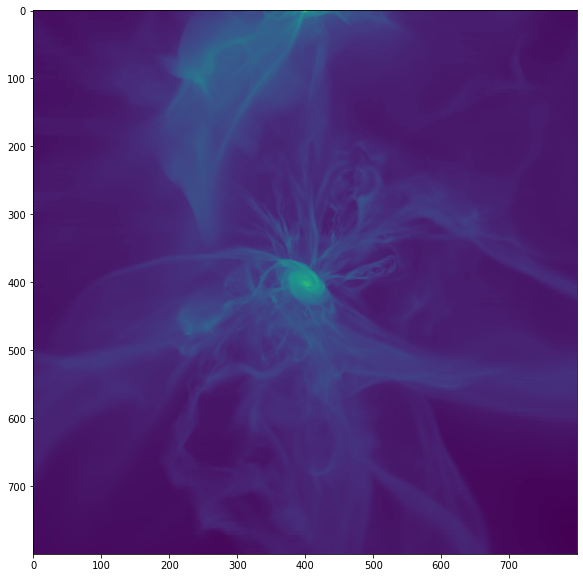

In [3]:
### Example of how to open one pickle and display it

p=choose_pickles(max_num_pickles=20,pickles_path='/lustre/astro/rlk/Image_only_pickles/Sink_91_HR/movie_frame_000111')
print(p[0])
i=p[0]
print(i[-23:-17])
print(i[-5:-4])
pickle_file=p[0]
file = open(pickle_file, "rb")
image = pickle.load(file)
#X, Y, image = pickle.load(file)
file.close()

#x=load_img_from_pickles(p[0])
plt.figure(figsize=(10,10))
plt.imshow(image**0.1)

### Step 2: Configure GPU devices and set a memory limit.

In [4]:

gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tensorflow.config.set_logical_device_configuration(
        gpus[0],
        [tensorflow.config.LogicalDeviceConfiguration(memory_limit=16384)])
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

4 Physical GPUs, 4 Logical GPUs


2021-11-01 18:53:33.169675: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-01 18:53:33.170731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-01 18:53:33.195584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-01 18:53:33.197053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:25:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-01 18:53:33.198481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:c1:00.0 name: A100-PCIE-40GB com

### Step 3:  Define and run the feature calculation, and extraction

In [5]:
def calculate_features(pickles_path='/groups/astro/rami/images/',max_num_images=20,model_name='vgg19' \
                       ,use_PCA=True,n_components=10, \
                       display_output=False,use_timing=True, \
                       save_features=True, features_folder='/lustre/hpc/astro/rami/features/'):


    print("Extracting features of %d projections \n which are in folder %s, \n using model %s \n. \n PCA used?:%s \n  "%(max_num_images,pickles_path,model_name,use_PCA))


    ### Load model from folder
    if use_timing:
        t0 = time.time()
    model=conv_model(model_name=model_name) 
    if use_timing:
        t1 = time.time()


    ### Randomly choose max_num_images amount of pickle files from the subfolders of pickles_path.
    pickles=choose_pickles(max_num_pickles=max_num_images,pickles_path=pickles_path)
    print("pickles shape:",np.shape(pickles))
    if use_timing:
        t2 = time.time()
        
        
        
    ### Extract features from those fils
    features=pickles_to_conv_features(pickles=pickles,model=model,model_name=model_name)
    print("Shape of features:",np.shape(features))
    print('\n')


    # Possibly reduce dimensionality of data
    if use_timing:
        t3 = time.time()
    if use_PCA==True:
        full_features=np.vstack((feature,features))
        reduced_full_features=reduce_PCA(full_features,n_components=n_components)
        reduced_feature=reduced_full_features[0,:]
        reduced_features=reduced_full_features[1:,:]
    elif use_PCA==False:
        reduced_features=features
    if use_timing:
        t4 = time.time()    


    ### Save the outputs.
    if save_features:
        import pickle
        reduced_features=np.array(reduced_features)
        for i in range(len(pickles)):
            name=pickles[i]
            specific_frame_folder =features_folder+model_name+'/feature_frame'+name[-23:-17]+'/'
            if not os.path.exists(specific_frame_folder):
                os.mkdir(specific_frame_folder)
            pickle_name=specific_frame_folder+'projection_'+name[-5:-4]+'.pkl'
            #print(pickle_name)
            with open(pickle_name, 'wb') as f:
                output=reduced_features[i,:]
                pickle.dump(output, f)
    if use_timing:
        t5=time.time()



    # Timing outputs
    ###########################################################################
    if use_timing:
        Dt1=t1-t0
        Dt2=t2-t1
        Dt3=t3-t2
        Dt4=t4-t3
        Dt5=t5-t4
        print('\n')
        print('\n')
        print('Dt1=%3.3f s:Model parameter loading: '%Dt1)

        print('Dt2=%3.3f s:Choosing the images from the folder'%Dt2)


        print('Dt3=%3.3f s:1) Image preprocessing and 2)loading of feature calculator'%Dt3)
        print('Dt4=%3.3f s:PCA'%Dt4)
        print('Dt5=%3.3f s:Saving '%Dt5)
        print('\n')

    return 0


In [6]:

calculate_features(pickles_path='/lustre/astro/rlk/Image_only_pickles/Sink_91_HR',max_num_images=3072,\
                 model_name='vgg16',\
                 use_PCA=False,n_components=100,\
                 display_output=True,use_timing=True,\
                 save_features=True, features_folder='/data/scratch/rami/features/')

Extracting features of 3072 projections 
 which are in folder /lustre/astro/rlk/Image_only_pickles/Sink_91_HR, 
 using model vgg16 
. 
 PCA used?:False 
  
Loading convolutional model: vgg16
0.90 sec to load the model parameters
0.00 sec to freeze the model layers
0.00 sec to show the model parameters
keeping 3072 pickles.
pickles shape: (3072,)


2021-11-01 19:07:05.200070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-01 19:07:05.204840: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199995000 Hz
2021-11-01 19:07:05.588076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-01 19:21:55.250456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


finished extracting features for 3072 images
Shape of features: (3072, 320000)






Dt1=0.896 s:Model parameter loading: 
Dt2=0.414 s:Choosing the images from the folder
Dt3=1585.748 s:1) Image preprocessing and 2)loading of feature calculator
Dt4=0.000 s:PCA
Dt5=3.107 s:Saving 




0